In [3]:
pip install camb 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install healpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
from matplotlib import pyplot as plt
import numpy as np
import math
import healpy as hp 
from tqdm import tqdm
import camb
import scipy

In [8]:
#For spherical harmonics
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm

from scipy.fftpack import ifftn, fftn
import matplotlib.cm as cm
from math import pi, sin, cos, sqrt, log, floor

plt.rcParams['figure.figsize'] = (12.0, 12.0)

In [32]:
import requests

url = 'https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_1024_R2.02_full.fits'

r = requests.get(url, allow_redirects=True)

open('cmb.fits', 'wb').write(r.content)


176209920

In [35]:
#Before we start plotting the CMB let's set a nice cmap
cmap = cm.RdBu_r
cmap.set_under("w") # sets background to white

In [36]:
planck_IQU_SMICA = hp.read_map('cmb.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/pranav/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


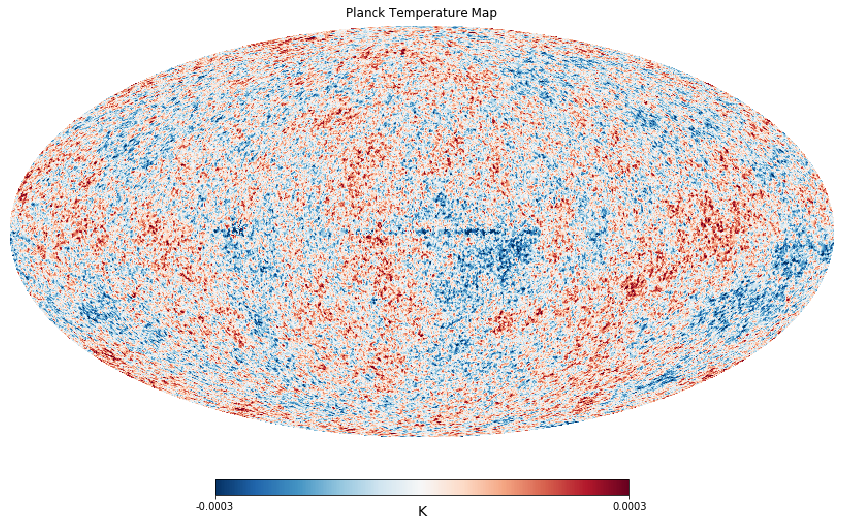

In [37]:
fig = plt.figure(1)
hp.mollview(planck_IQU_SMICA, min=-0.0003, max=0.0003, title='Planck Temperature Map',
            fig=1, unit='K',cmap=cmap)

/home/pranav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
No handles with labels found to put in legend.


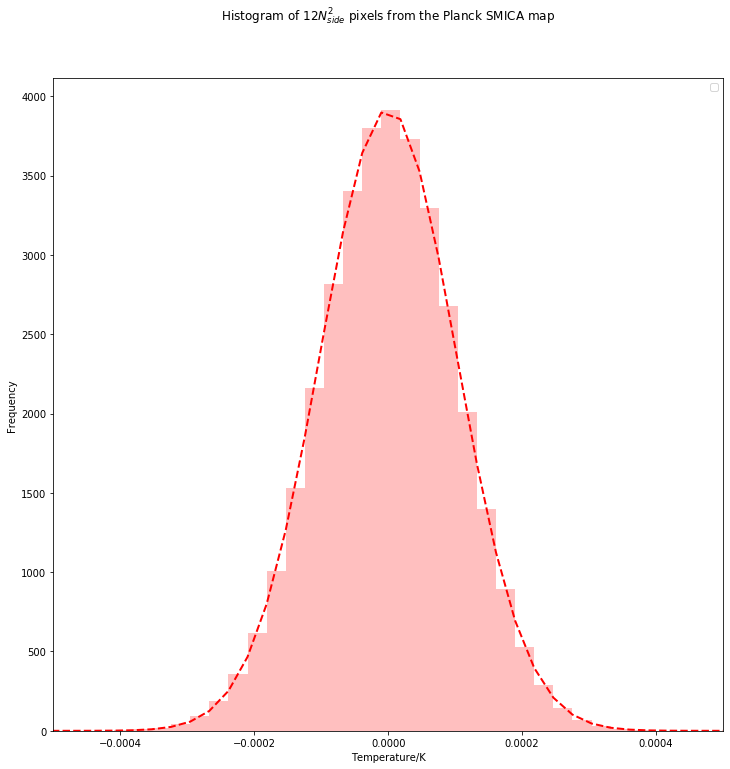

In [38]:
from scipy.stats import norm
import matplotlib.mlab as mlab

# best fit of data
(mu, sigma) = norm.fit(planck_IQU_SMICA)
# the histogram of the data
n, bins, patches = plt.hist(planck_IQU_SMICA, 60, normed=1, facecolor='r', alpha=0.25)

# add a 'best fit' line
y = scipy.stats.norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Temperature/K')
plt.ylabel('Frequency')
plt.title(r'Histogram of $12N_{side}^2$ pixels from the Planck SMICA map', y=1.08)
plt.xlim(-0.0005, 0.0005)

plt.legend()

plt.show()

<h1 style="text-align:center;"> CMB and Gaussian Random Fields  </h1>

### The CMB is defined as a 2D random field $y(\hat{r})= \frac{\delta T(\hat{r})}{T_{CMB}}$ where $\hat{r}$ spans the celestial sphere.




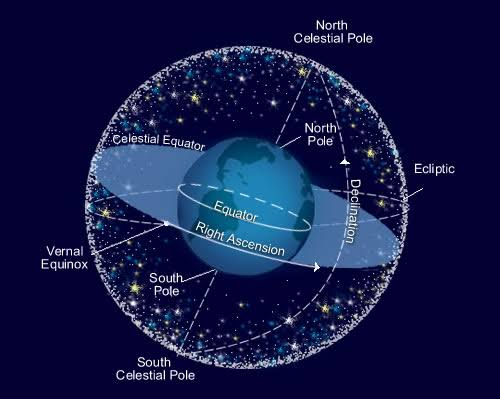


### This is samples onto a vector y = [y1,y2,y3,.....yn] where N is the number of pixels

### The CMB is very close to a gaussian random field so y will form a gaussian with mean zero and PDF:
### $P(y_1,...,y_n) =\frac{1}{(2\pi)^{N/2} | C|^{1/2}}\exp(-\frac{1}{2}{\bf y.C^{-1}.y^{\dagger}})$

### where $C$ is the covariance matrix* $C = \langle {\bf y.y}^{\dagger}\rangle$


*More on gaussian distributions: http://cs229.stanford.edu/section/gaussians.pdf

<h1 style="text-align:center;"> Spherical Harmonics and Temperature Fluctuations</h1>


## $Y_{lm}$


$Y_{00}(\theta,\phi) = \frac{1}{\sqrt{4\pi}}$

$Y_{10}(\theta,\phi) = \mathrm{i}\sqrt{\frac{3}{4\pi}}\cos\theta$

$Y_{1,\pm1}(\theta,\phi) = \mp \mathrm{i}\sqrt{\frac{3}{8\pi}}\sin\theta \,\mathrm{e}^{\pm i\phi}$

$Y_{20}(\theta,\phi) = \sqrt{\frac{5}{16\pi}}(1 - 3\cos^2\theta)$

$Y_{2,\pm1}(\theta,\phi) = \pm \mathrm{i}\sqrt{\frac{15}{8\pi}}\cos\theta\sin\theta \,\mathrm{e}^{\pm i\phi}$

$Y_{2,\pm2}(\theta,\phi) = -\sqrt{\frac{15}{32\pi}}\sin^2\theta \,\mathrm{e}^{\pm 2i\phi}$

## Temperature is defined on the sphere i.e. it is a function of $\theta$ and $\phi$ so it can be decomposed as a sum of spherical harmonics:

# $T(\hat{n}) = \sum\limits_{l,m}a_{T,lm}Y_{lm}(\hat{n})$

### This is the analogue of Fourier decomposition in flat space e.g. 2D or 3D fields are a function of spatial coordinates.

### The amplitudes $a_{lm}$ are the complex spherical harmonic coefficients. They have a Gaussian distribution in the standard inflationary model.

#### * $l$ is related to angular scale on the sky

#### * $m$ is related to the orientation of this mode on the sky

### The probability density function (PDF) for the distribution of $a_{lm}$ is

# $P(a_{lm}) = \frac{1}{\sqrt{2\pi C_l}}e^{-a^2_{lm}/2C_l} $

### $a_{lm}$ are zero mean Gaussian random variables

### $C_l$ is the angular power spectrum (the variance of the distribution.)

#### The variance of the field on a given angular scale is: 

#### $\langle a^*_{l'm'}a_{lm} \rangle = C_l\delta_{l'l}\delta_{m'm}$

We only have one sky to observe so our best estimate comes from this average over $m$

Statistical isotropy: There is no correlation between the $a_{lm}$ unless $l=l'$ and $m=m'$

In [14]:
# http://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/


phi = np.linspace(0, np.pi, 100) #Polar (colatitudinal) coordinate
theta = np.linspace(0, 2*np.pi, 100) #Azimuthal (longitudinal) coordinate
phi, theta = np.meshgrid(phi, theta)

In [15]:
# The Cartesian coordinates of the unit sphere


x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

In [16]:
def norm_harmonic(l, m, theta, phi):
    # Calculate the spherical harmonic Y(l,m) and normalize to [0,1]
    fcolors = sph_harm(m, l, theta, phi).real
    fmax, fmin = fcolors.max(), fcolors.min()
    fcolors = (fcolors - fmin)/(fmax - fmin)
    return fcolors

In [17]:
def plot_harmonic(fcolors, x, y, z):
    # Set the aspect ratio to 1 so our sphere looks spherical
    fig = plt.figure(figsize=plt.figaspect(1.))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.RdBu_r(fcolors))
    # Turn off the axis planes
    ax.set_axis_off()
    plt.show()

In [24]:
def plot_ax(fig, fcolors, x, y, z, numplots, pos):
    ax = fig.add_subplot(1, numplots, pos, projection='3d')
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.RdBu_r(fcolors))
    # Turn off the axis planes
    ax.set_axis_off()

In [25]:
def plot_l(l):
    fig = plt.figure(figsize=(12, 12))
    for m in range(0, l + 1):
        plot_ax(fig, norm_harmonic(l, m, theta, phi), x, y, z, l + 1, m + 1)
    plt.show()

Now let's plot them.

The first spherical harmonic is just a constant value across the sphere with no angular dependence.

After that, things get interesting!

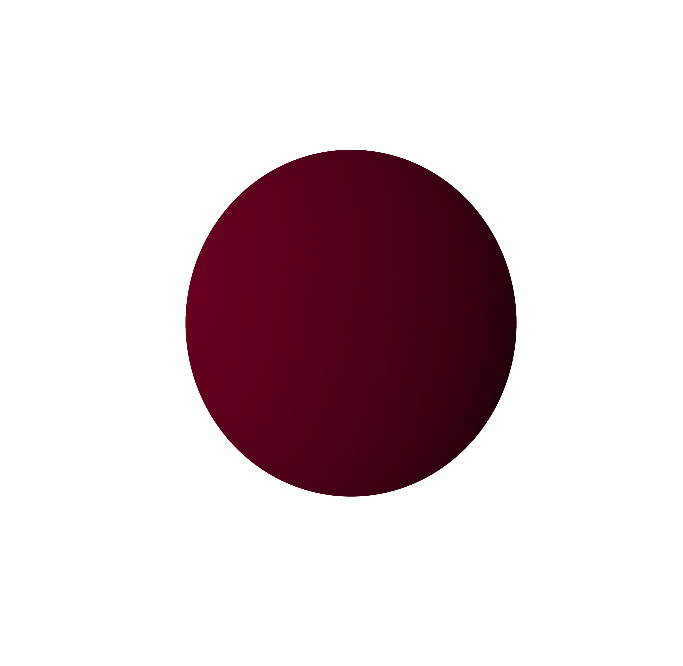

In [26]:
l = 0; m = 0
fcolors = sph_harm(m, l, theta, phi).real
plot_harmonic(fcolors/fcolors, x, y, z)

## The monopole

What COBE actually saw in the temperature of the CMB was at first glance remarkably boring: It is uniform up to 1 part in 1000.


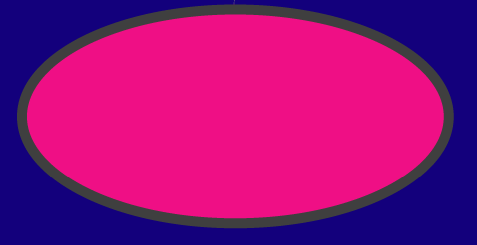

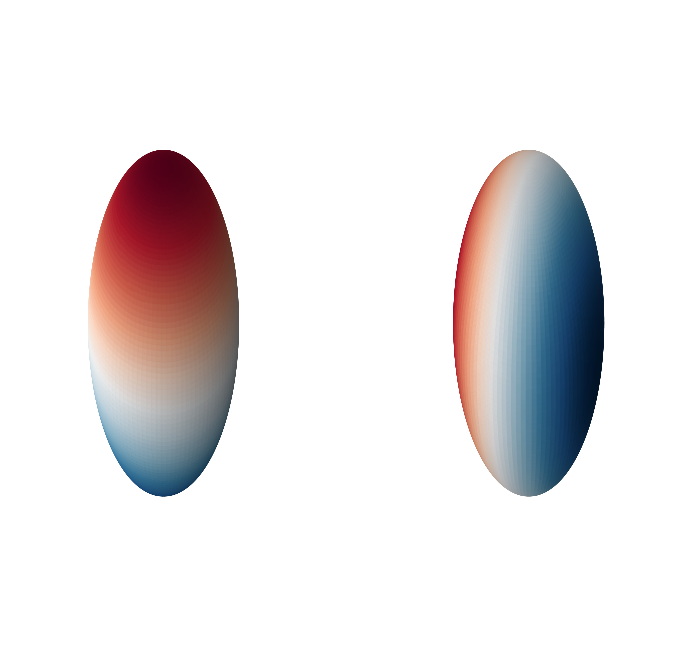

In [27]:
plot_l(1)

## Dipole

At the level of 1 part in 1000, the CMB temperature varies because of our motion with respect to it.

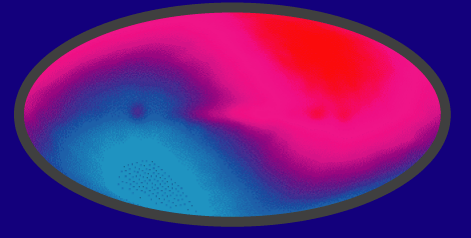

Aside from some deviations about the equator, this pattern is a pure dipole.  A dipole has its maxima and minima (red and blue here) pointed in opposite directions on the sky.  This pattern is generated simply because we ourselves are moving with respect to the CMB and its temperature appears redshifted or blueshifted by the Doppler effect.



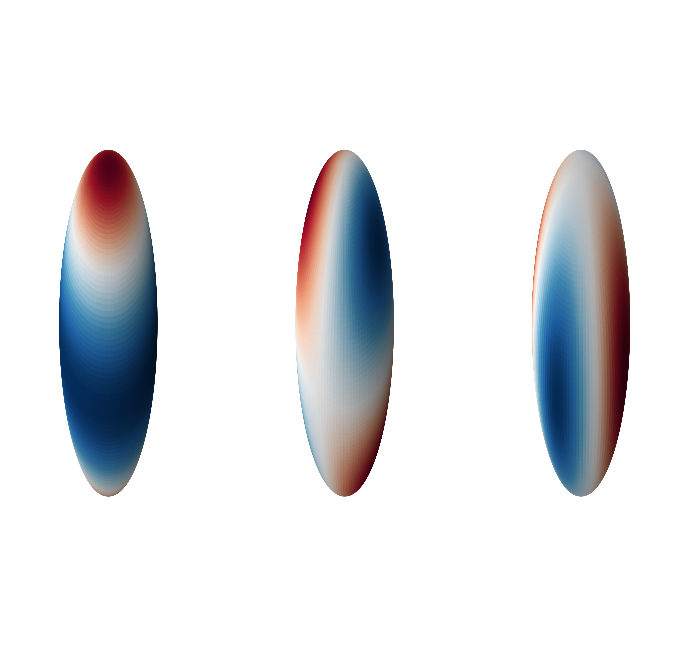

In [29]:
plot_l(2)

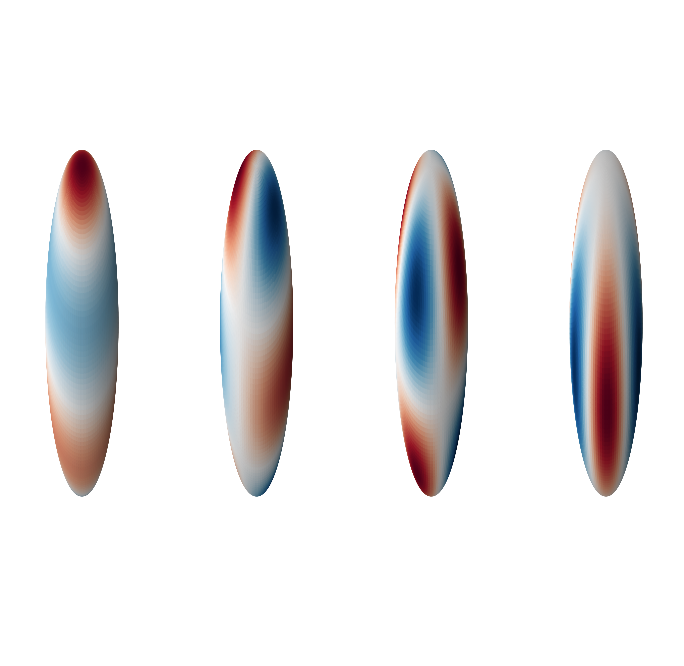

In [30]:
plot_l(3)

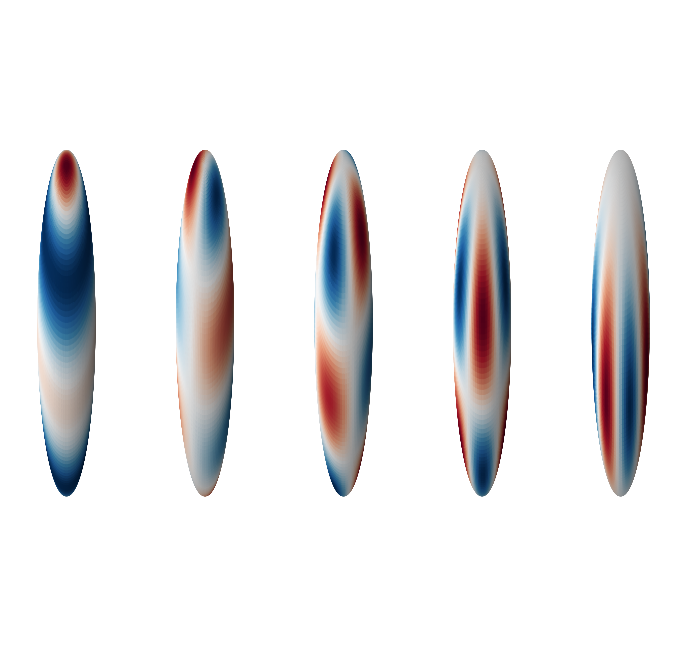

In [31]:
plot_l(4)

In [39]:
url = 'https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/cosmoparams/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt'
r = requests.get(url, allow_redirects=True)

open('powerspectra.txt', 'wb').write(r.content)

205647

In [40]:
#read in theoretical best fit power spectra from Planck 2015 data
planck_theory_cl = np.loadtxt('powerspectra.txt')

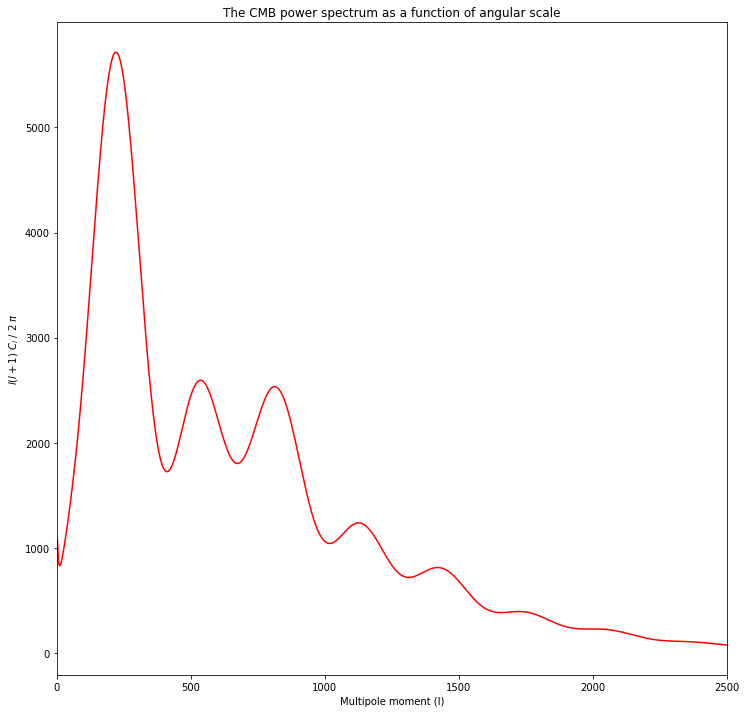

In [49]:
plt.plot(planck_theory_cl[:,0], planck_theory_cl[:,1], '-r')
plt.title("The CMB power spectrum as a function of angular scale")
plt.xlabel("Multipole moment (l)")
plt.ylabel("$l(l+1)$ $C_l$ / 2 $\pi$")
plt.xlim(0,2500)
plt.show()


<img src="http://background.uchicago.edu/~whu/intermediate/clcurvature.gif">

## Here is a static image showing the multipole components up to l=3



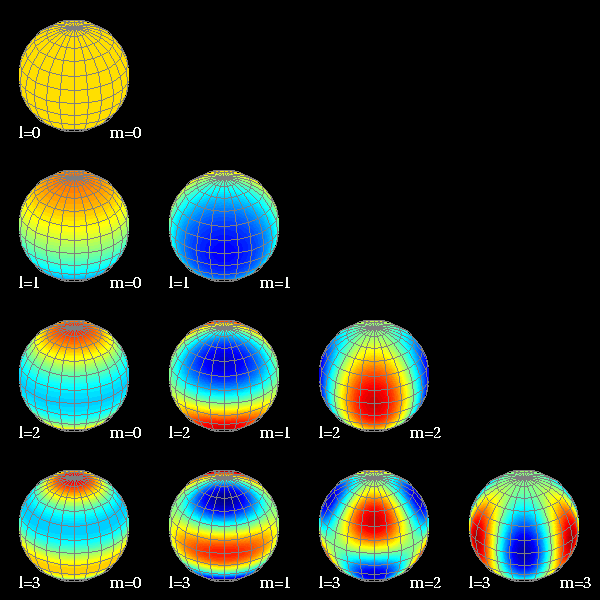




##                                Individual CMB Multipoles Animation




<img src="http://spud.spa.umn.edu/~pryke/logbook/20000922/cu_1000_anim.gif">

In [28]:
#Object storing the parameters for a CAMB calculation, including cosmological parameters
cp = camb.model.CAMBparams() 

print(cp)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0
 omch2 = 0.0
 omk = 0.0
 omnuh2 = 0.0
 H0 = 67.0
 TCMB = 2.7255
 YHe = 0.24
 num_nu_massless = 3.046
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_delta_neff = False
 nu_mass_degeneracies = []
 nu_mass_fractions = []
 nu_mass_numbers = []
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 0.0
   nrunrun = 0.0
   nt = -0.0
   ntrun = -0.0
   r = 0.0
   pivot_s